**Do not change this version from 0.45**

In [ ]:
pip install qiskit==0.45 qiskit_aer

INFO: pip is looking at multiple versions of qiskit-aer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import math
import time
import scipy
from matplotlib import pyplot as plt
from matplotlib import pylab

# Importing standard Qiskit libraries
from qiskit import *
from qiskit import quantum_info
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
import qiskit.quantum_info as qi
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.primitives import Sampler as Sampler
from qiskit import Aer
from qiskit import execute,  BasicAer #execute
from qiskit.circuit.random import random_circuit
from qiskit import QuantumRegister
import numpy as np
from qiskit import ClassicalRegister
from qiskit.circuit.library import RYGate

#Paulis
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

#|0> and |1>
one = np.array([0,1])
zero = np.array([1,0])

def tensor(a,b,c):
  """
  Returns the tensor product of numpy arrays a,b, and c.
  """
  return np.kron(np.kron(a,b),c)

def tensorbig(lst):
    """
    Returns the tensor product of the arrays in lst.

    Preconditions:
    - lst contains only Numpy arrays
    """
    result = lst[0]
    for i in range(1, len(lst)):
        result = np.kron(result, lst[i])
    return result


def unitary(U):
  """Returns whether a numpy matrix is unitary"""
  return np.allclose(np.eye(U.shape[0]), np.dot(U, U.conjugate().T))


def flip(counts):
  """
  Given a dictionary counts with a string key, it returns
  a new dictionary with the key reversed and the value the same.

  Used for switching the endianness of the measurements.
  """
  res = {}
  for k,v in counts.items():
    res[k[::-1]] = v
  return res



In [ ]:
#PUT DECAY PARAMETERS HERE
kappa = 64.5
gamma = np.sqrt(.4)


kappa = np.sqrt(kappa)
zero2 = np.array([1,0,0,0])
one2 =  np.array([0,1,0,0])
two = np.array([0,0,1,0])
three = np.array([0,0,0,1])

#Destroy operator
a = (np.outer(zero2, one2) + np.sqrt(2) * np.outer(one2, two) + np.sqrt(3) * np.outer(two, three))

sigma = np.outer(zero, one)
isigma = tensor(I, I, sigma)

def next_power(n):
    """Finds the first number >= n that is also a
    power of 2.

    Used for figuring out the size and padding of the JMatrix."""
    power = 1
    while power < n:
        power <<= 1
    return power

def makeJ(type_J):
  """
  Makes the J Matrix for a certain subsystem (cavity or emitter). R

  Parameter type_J: the type of J matrix to make. 0 signifies cavity, anything
  else is an emitter.
  """
  if type_J == 0:
    return np.block([[np.zeros((4,4)), kappa * a.conjugate().T], [kappa * a, np.zeros((4,4)) ]])
  else:
    return np.block([[np.zeros((2,2)), gamma * sigma.conjugate().T], [gamma * sigma, np.zeros((2,2))]])



In [ ]:
#PUT HAMILTONIAN PARAMETERS HERE
wc = 0
we =[200, 500, 750, 400, 150, 300, 575, 150]
g = 100

a = (np.outer(zero2, one2) + np.sqrt(2) * np.outer(one2, two) + np.sqrt(3) * np.outer(two, three))

def makeH(type_H, emitter, drive = False, tn = None):
  """
  Makes and returns the Hamiltonian matrix.

  Parameter type_H: which part of the Hamiltonian to make
  Precondition: type_H is either 0, 1, 2.

  Parameter emitters: the number of emitters
  Precondition: emitters is a positive int.

  Parameter drive: Whether or not to have a drive
  Precondition: drive is a boolean.

  Parameter tn: the Trotterization depth
  Precondition: tn is a positive integer.
  """
  wd = wc-g
  pump_a = tensorbig([a, I, I, I, I])

  #the term outside the sum
  adagaN = np.dot(a.conjugate().T, a)
  Hn = wc*adagaN
  if type_H == 0:
    return g * adagaN + (kappa)/2 * (a + a.conjugate().T)
  elif type_H == 1:
    return (we[emitter]-wd) * np.outer(one, one)
  elif type_H == 2:
    return g * (np.dot(tensor(I,I ,sigma.conjugate().T), tensorbig([a, I])) + np.dot(tensorbig([a.conjugate().T, I]), tensor(I,I,sigma)))






Let's turn our two matrices into quantum gates.

The unitaries are represented by $e^{-iJ\sqrt{t/N}}$ and $e^{-iHt/N}$.

In [ ]:
def makeU(argl, t, N, type_gate, emitter = 1, tdepth = 1):
  """
  Creates the unitary gates for Split JMatrix method.

  Parameter argl: the indicator for which gate to make.
  Precondition: argl is either 'j' or 'H'

  Parameter t: the simulation time.
  Precondition: t is a positive float.

  Parameter N: the number of steps in the algorithm.
  Precondition: N is a positive int.

  Parameter type_gate: the type of gate to make. 0 signifies cavity, anything
  else is an emitter.
  Precondition: type_gate is a positive int.

  Parameter emitter: the emitter index when applicable. Starts from 0.
  Precondition: emitter is an int between 0 and emitters-1 inclusive.

  Parameter tdepth: the Trotterization depth.
  Precondition: tdepth is a positive int.
  """
  if argl == "j":
    return UnitaryGate(scipy.linalg.expm(-1j * makeJ(type_gate) * np.sqrt(t/N)))
  if argl == "H":
    return UnitaryGate(scipy.linalg.expm(-1j * makeH(type_gate, emitter = emitter , drive = True, tn = t/N) * t/(N*tdepth)))


In [ ]:
def trace_cav(counts):
  """
  Given a counts dictionary of the full cavity-emitters system,
  returns a new dictionary for only the cavity counts.

  The cavity shold correspond to the first two indices of the key.
  """
  res = {}
  for key in counts:
    if key[:2] in res:
      res[key[:2]] += counts[key]
    else:
      res[key[:2]] = counts[key]
  return res

def trace_emit(counts, ind):
  """
  Given a counts dictionary of the full cavity-emitters system,
  returns a new dictionary for only the counts for one emitter.

  Parameter ind: the emitter index. Starts from 0.
  Precondition: ind is an int between 0 and emitters-1 inclusive.
  """
  res = {"0": 0, "1": 0}
  for key in counts:
    if key[2+ind] == "0":
      res["0"] += counts[key]
    else:
      res["1"] += counts[key]
  return res

def JmethodN(emitters = 1, start_photons = 1, t = .1, N = 100, shots = 1000, trotter_depth = 2):
  """Calculates the population and G2 for the system for a given time.

  It creates a quantum circuit in Qiskit, then applies the two gates and traces
  out the ancilla register. Then, it measures the system qubits and
  does some post-measurement calculation to find the populations and G2.
  """

  #Get the gates
  Jcav, Jemit = makeU('j', t, N, 0), makeU('j', t, N, 1)
  Hcav = [makeU('H', t, N, 0, emitter = None, tdepth = trotter_depth)]
  Hemit = [makeU('H', t, N, 1, emitter = i, tdepth = trotter_depth) for i in range(emitters)]
  Hmix = [makeU('H', t, N, 2, emitter = None, tdepth = trotter_depth)]

  #Make the circuit
  ancillas = 1
  ancilla = QuantumRegister(1, name = '0_ancilla')
  cavity = QuantumRegister(2, name='cavity')
  emitter = QuantumRegister(emitters, name='emitter')
  classical = ClassicalRegister(2 + emitters)
  circ = QuantumCircuit(ancilla, cavity, emitter, classical)

  #Pump the cavity with photons.
  if start_photons > 1:
   circ.x(cavity[0])
  if start_photons % 2 == 1:
    circ.x(cavity[1])

  #Apply J and H repeatedly, then trace out the ancilla.
  circ.barrier()
  for _ in range(N):
    circ.reset(ancilla)
    circ.append(Jcav, reversed([ancilla[i] for i in range(ancillas)] + [cavity[0], cavity[1]]))
    for i in range(emitters):
      circ.reset(ancilla)
      circ.append(Jemit, reversed([ancilla[i] for i in range(ancillas)] + [emitter[i]]))

    circ.append(Hcav[0], reversed([cavity[0],cavity[1]]))
    for i in range(emitters):
        circ.append(Hemit[i], [emitter[i]])
        circ.append(Hmix[0], [3+i, 2, 1])

    for i in reversed(range(emitters)):
        circ.append(Hmix[0], [3+i, 2, 1])
        circ.append(Hemit[i], [emitter[i]])
    circ.append(Hcav[0], reversed([cavity[0],cavity[1]]))


    circ.barrier()
  circ.reset(ancilla)

  #Measure the system
  circ.measure(range(ancillas, ancillas + 2 + emitters), range(2+emitters))
  timestart = time.time()
  backend = Aer.get_backend("qasm_simulator")

  job = execute(circ, backend, shots=shots)
  result = job.result()
  counts = result.get_counts()
  counts = flip(counts)
  cav_counts = trace_cav(counts)
  population = (3 * cav_counts.get("11", 0) + 2 * cav_counts.get("10", 0) + 1 * cav_counts.get("01", 0))/shots
  emitvals = [trace_emit(counts, i).get("1")/shots for i in range(emitters)]
  try:
    g2 = (6 * cav_counts.get("11", 0) + 2 * cav_counts.get("10", 0))/(shots * population ** 2)
  except ZeroDivisionError:
    g2 = 0

  return g2, population, emitvals, cav_counts

JmethodN(emitters = 1, start_photons = 1, t = 10, N = 1000, shots = 500)

(0.5333333333333333, 0.15, [0.032], {'01': 69, '10': 3, '00': 428})

In [ ]:
def g2_experiment(t, shots):
  """
  Subroutine to calculate g2 values. Shots should be relatively high.

  Parameter t: the simulation time.
  Precondition: t is a positive float.

  Parameter shots: the number of shots to take.
  Precondition: shots is a positive int.
  """
  counts = JmethodN(emitters = 8, start_photons = 1, t = t, N = 1000, shots = shots)[-1]
  population = (3 * counts.get("11", 0) + 2 * counts.get("10", 0) + 1 * counts.get("01", 0))/shots
  try:
    g2 = (6* counts.get("11", 0) + 2 * counts.get("10", 0))/(shots * (population ** 2))
  except ZeroDivisionError:
    g2 = 0

  return counts, g2

for _ in range(10):
  print(g2_experiment(1.5, 3000))

({'10': 32, '01': 324, '00': 2644}, 1.2753746413008822)
({'01': 271, '00': 2696, '10': 30, '11': 3}, 2.0242214532871974)
({'01': 262, '11': 2, '00': 2713, '10': 23}, 1.7647774757596657)
({'10': 26, '11': 1, '01': 304, '00': 2669}, 1.3500826343681378)


Working on iteration 0
Working on iteration 10
Working on iteration 20
Working on iteration 30
Working on iteration 40
Working on iteration 50
Working on iteration 60
Working on iteration 70
Working on iteration 80
Working on iteration 90


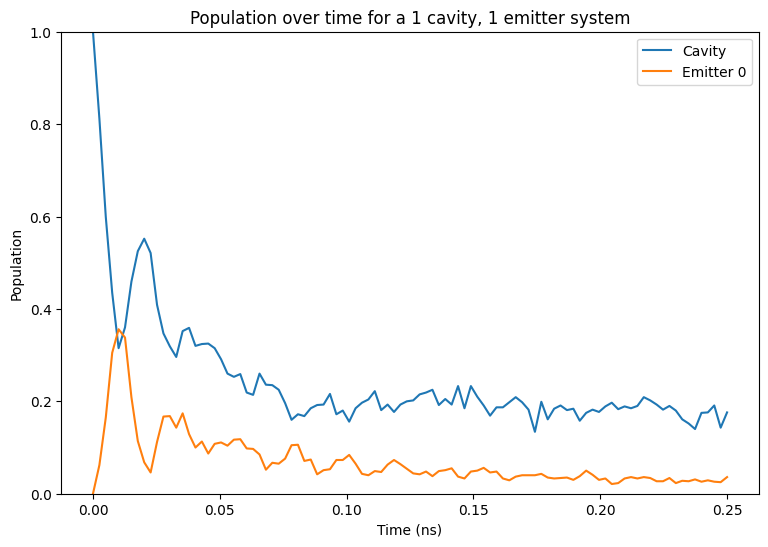

[1.0, 0.812, 0.599, 0.435, 0.315, 0.36, 0.459, 0.525, 0.552, 0.521, 0.409, 0.347, 0.319, 0.296, 0.352, 0.359, 0.32, 0.324, 0.325, 0.315, 0.291, 0.26, 0.253, 0.259, 0.219, 0.214, 0.26, 0.236, 0.235, 0.225, 0.196, 0.16, 0.172, 0.168, 0.185, 0.192, 0.193, 0.216, 0.172, 0.18, 0.156, 0.185, 0.197, 0.204, 0.222, 0.181, 0.193, 0.177, 0.193, 0.2, 0.202, 0.215, 0.219, 0.225, 0.192, 0.205, 0.193, 0.233, 0.185, 0.233, 0.21, 0.191, 0.169, 0.187, 0.187, 0.198, 0.209, 0.198, 0.182, 0.134, 0.199, 0.161, 0.184, 0.191, 0.181, 0.184, 0.158, 0.175, 0.182, 0.177, 0.189, 0.197, 0.183, 0.189, 0.185, 0.19, 0.209, 0.202, 0.193, 0.182, 0.19, 0.18, 0.161, 0.152, 0.14, 0.175, 0.176, 0.191, 0.143, 0.176]
[[0.0, 0.062, 0.165, 0.305, 0.356, 0.338, 0.209, 0.114, 0.068, 0.046, 0.112, 0.167, 0.168, 0.143, 0.174, 0.129, 0.1, 0.113, 0.087, 0.108, 0.111, 0.104, 0.117, 0.118, 0.098, 0.097, 0.085, 0.052, 0.067, 0.065, 0.076, 0.105, 0.106, 0.071, 0.074, 0.042, 0.051, 0.053, 0.073, 0.073, 0.084, 0.065, 0.043, 0.04, 0.049, 0.

In [ ]:
def runN(N, emitters, start_photons = 1):
  """
  Plots the measurements of the system over time.

  Generates a list of times to take measurements. Then, for each times, calls
  JmethodN and gets the populations of the cavity and emitters. Then, plots them
  below.

  Parameter N: the number of times to apply J and H each time the JMethod is run.
  Precondition: N is a positive integer.

  Parameter emitters: Number of emitters in the system
  Precondition: emitters is a positive integer

  Parameter start_photons: the number of photons to pump the cavity with.
  Precondition: start_photons is either 0,1,2, or 3.
  """
  tlist = np.linspace(0, .25, 100)

  poplist = []
  emitlist = [[] for i in range(emitters)]
  for i in range(len(tlist)):
    if i %10 == 0:
      print("Working on iteration " + str(i))

    g2, pop, em, _ = JmethodN(emitters = emitters, start_photons = start_photons, t = tlist[i], N = N, trotter_depth=2)

    poplist.append(pop)
    for j in range(len(em)):
      emitlist[j].append(em[j])
  plt.figure(figsize=(9,6))

  #Make the plot
  plt.plot(tlist, poplist, label = 'Cavity')
  for j in range(len(emitlist)):
    plt.plot(tlist, emitlist[j], label = str(j)+' Emitter')
  plt.legend(labels = ['Cavity'] + ['Emitter ' + str(i) for i in range(emitters)])

  # Adding labels and title
  plt.xlabel('Time (ns)')
  plt.ylabel('Population')
  plt.ylim(0,1)
  plt.title('Population over time for a 1 cavity, ' + str(emitters) + ' emitter system')

  plt.show()
  print(poplist)
  print(emitlist)

runN(30, 1, 1)